# import

In [1]:
import sys 
sys.path.append('C:\\Users\\Nuo.Chen\\PycharmProjects\\Imbalance_price_forecast')
from utils.import_packages import *
# from data_gathering.prepare_data import *

from xgboost import XGBClassifier, XGBRegressor
from models.evaluation import *

In [2]:
train_df = pd.read_excel(data_folder_path + '/train.xlsx')
test_df = pd.read_excel(data_folder_path + '/test.xlsx')

## cross validation

In [57]:
def down_sample_train(train,target,down_ratio):
    # down sample click = 0 data so as 'len(click = 0) = n* len(click = 1)'
    
    pos_rows = train[ train[target] == 1 ]
    neg_rows = train[ train[target] == 0 ]
    
    np.random.seed(666)
    sample_pos_index = np.random.choice( pos_rows.index, math.floor(len(pos_rows)*down_ratio), replace = False)
    sample_pos_df = pos_rows.loc[sample_pos_index]
    
    new_train = pd.concat([sample_pos_df, neg_rows], axis = 0)
    
    return new_train

In [58]:
def recalibration(prediction,down_ratio):
    q = prediction/( prediction + (1-prediction)/down_ratio)
    return q

In [67]:
def simple_train(target, model, feat_params, df, down_ratio=0.1):
    train, test = train_test_split(df, None, splitBySize = True)
    train = down_sample_train(train, target, down_ratio)
    
    train_x, train_y = classification_feat_pipeline(feat_params, train)
    test_x, test_y = classification_feat_pipeline(feat_params, test)
    
    train_model = model().fit(train_x, train_y[target])
    
    # recalibration
    train_prob = train_model.predict_proba(train_x)[:,1]
    test_prob = train_model.predict_proba(test_x)[:,1]
    
    train_pred = recalibration(train_prob, down_ratio)
    test_pred = recalibration(test_prob, down_ratio)
    
    train_metrics = Evaluator(train_pred, train_y[target]).classification_metrics()
    test_metrics = Evaluator(test_pred, test_y[target]).classification_metrics()
    print('train: auc = {}, acc = {}'.format(train_metrics['AUC'], train_metrics['Accuracy']))
    print('test: auc = {}, acc = {}'.format(test_metrics['AUC'], test_metrics['Accuracy']))
    
    return train_model

model = simple_train('DA>TAKE', XGBClassifier, lag_dict2, train_df, down_ratio = 0.3)

train: auc = 1.0000, acc = 99.2633
test: auc = 0.5535, acc = 32.1198


In [68]:
test_x, test_y = classification_feat_pipeline(lag_dict2, test_df)
test_y = test_y['DA>TAKE']
test_proba = model.predict_proba(test_x)[:,1]
test_pred = recalibration(test_proba, 0.3)

metrics2 = Evaluator(test_proba, test_y).classification_metrics()
metrics2

{'AUC': '0.4810', 'Accuracy': 23.138}

In [69]:
test_pred

array([5.5154711e-03, 4.7441754e-03, 3.5736782e-03, ..., 4.5301604e-05,
       4.2024007e-05, 4.7998266e-05], dtype=float32)

In [34]:
def train_validation(target, model, feat_params, df, n_folds=2, print_temp_info=True):
    results = defaultdict(list)
    ts_split = TimeSeriesSplit(n_splits=n_folds)
    feat_cols = None

    for fold, (train_index, test_index) in enumerate(ts_split.split(df), 1):
        start_time = time.time()
        print('Fold:{}'.format(fold))
        cv_train = df.iloc[train_index, :]
        cv_test = df.iloc[test_index, :]
        cv_train = down_sample_train(cv_train, target)
        
        train_x, train_y = classification_feat_pipeline(feat_params, cv_train)
        
        test_x, test_y = classification_feat_pipeline(feat_params, cv_test)
        feat_cols = train_x.columns

        cv_model = model()
        cv_model.fit(train_x, train_y[target])
#             train_pred = cv_model.predict_proba(train_x)[:, 1]
#             test_pred = cv_model.predict_proba(test_x)[:, 1]
        train_pred = cv_model.predict(train_x)
        test_pred = cv_model.predict(test_x)

        train_metrics = Evaluator(train_pred, train_y[target]).classification_metrics()
        test_metrics = Evaluator(test_pred, test_y[target]).classification_metrics()
        results['auc'].append(test_metrics['AUC'])
        results['models'].append(cv_model)

        if print_temp_info:
            print('train:')
            print(train_metrics)
            print('test:')
            print(test_metrics)
            print('takes:{} min\n'.format(round((time.time() - start_time) / 60, 2)))

    return results, feat_cols


# DA > TAKE

## feat pipeline

In [41]:
lag_values2 = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
classy_lag_dict = {'take_from_system_price':lag_values2['yesterday'],\
           'feed_into_system_price':lag_values2['yesterday'],\
           'DA-price':lag_values2['around_time_before']}
                   
#            'system_purchase_vol':lag_values2['around_time_before'],\
#            'system_sell_vol':lag_values2['around_time_before'],\
#            'system_absolute_vol':lag_values2['around_time_before'],\
#            'wind_value':lag_values2['around_time_before']}

In [43]:
def classification_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y

## train

In [44]:
out2,feat_cols2 = classy_cross_validation('DA>TAKE',XGBClassifier,classy_lag_dict,train_df) 

Fold:1
train:
{'AUC': '1.0000', 'Accuracy': 100.0}
test:
{'AUC': '0.4998', 'Accuracy': 21.975}
takes:0.33 min

Fold:2
train:
{'AUC': '0.9998', 'Accuracy': 99.9769}
test:
{'AUC': '0.5107', 'Accuracy': 32.466}
takes:0.43 min



## feat importance

In [45]:
model_auc = out2['auc']
best_model2 = out2['models'][model_auc.index(max(model_auc))]

plot_feature_importance(best_model2, feat_cols2)[-10:]

,importances,features
120,0.014620,take_from_system_price_99
121,0.017544,take_from_system_price_100
117,0.017544,take_from_system_price_96
12,0.019006,sin_PTE
310,0.020468,DA-price_97
197,0.021930,take_from_system_price_176
118,0.023392,take_from_system_price_97
10,0.036550,sin_day
11,0.070175,cos_day
9,0.071637,cos_month


## test

In [46]:
test_x, test_y = classification_feat_pipeline(lag_dict2, test_df)
test_y = test_y['DA>TAKE']
test_proba = best_model2.predict_proba(test_x)[:,1]
test_pred = best_model2.predict(test_x)

metrics2 = Evaluator(test_proba, test_y).classification_metrics()
metrics2

ValueError: feature_names mismatch: ['solar_value', 'solar_maxvalue', 'solar_minvalue', 'wind_value', 'wind_maxvalue', 'wind_minvalue', 'sin_weekday', 'cos_weekday', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_PTE', 'cos_PTE', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'PTE_1', 'PTE_2', 'PTE_3', 'PTE_4', 'PTE_5', 'PTE_6', 'PTE_7', 'PTE_8', 'PTE_9', 'PTE_10', 'PTE_11', 'PTE_12', 'PTE_13', 'PTE_14', 'PTE_15', 'PTE_16', 'PTE_17', 'PTE_18', 'PTE_19', 'PTE_20', 'PTE_21', 'PTE_22', 'PTE_23', 'PTE_24', 'PTE_25', 'PTE_26', 'PTE_27', 'PTE_28', 'PTE_29', 'PTE_30', 'PTE_31', 'PTE_32', 'PTE_33', 'PTE_34', 'PTE_35', 'PTE_36', 'PTE_37', 'PTE_38', 'PTE_39', 'PTE_40', 'PTE_41', 'PTE_42', 'PTE_43', 'PTE_44', 'PTE_45', 'PTE_46', 'PTE_47', 'PTE_48', 'PTE_49', 'PTE_50', 'PTE_51', 'PTE_52', 'PTE_53', 'PTE_54', 'PTE_55', 'PTE_56', 'PTE_57', 'PTE_58', 'PTE_59', 'PTE_60', 'PTE_61', 'PTE_62', 'PTE_63', 'PTE_64', 'PTE_65', 'PTE_66', 'PTE_67', 'PTE_68', 'PTE_69', 'PTE_70', 'PTE_71', 'PTE_72', 'PTE_73', 'PTE_74', 'PTE_75', 'PTE_76', 'PTE_77', 'PTE_78', 'PTE_79', 'PTE_80', 'PTE_81', 'PTE_82', 'PTE_83', 'PTE_84', 'PTE_85', 'PTE_86', 'PTE_87', 'PTE_88', 'PTE_89', 'PTE_90', 'PTE_91', 'PTE_92', 'PTE_93', 'PTE_94', 'PTE_95', 'PTE_96', 'take_from_system_price_96', 'take_from_system_price_97', 'take_from_system_price_98', 'take_from_system_price_99', 'take_from_system_price_100', 'take_from_system_price_101', 'take_from_system_price_102', 'take_from_system_price_103', 'take_from_system_price_104', 'take_from_system_price_105', 'take_from_system_price_106', 'take_from_system_price_107', 'take_from_system_price_108', 'take_from_system_price_109', 'take_from_system_price_110', 'take_from_system_price_111', 'take_from_system_price_112', 'take_from_system_price_113', 'take_from_system_price_114', 'take_from_system_price_115', 'take_from_system_price_116', 'take_from_system_price_117', 'take_from_system_price_118', 'take_from_system_price_119', 'take_from_system_price_120', 'take_from_system_price_121', 'take_from_system_price_122', 'take_from_system_price_123', 'take_from_system_price_124', 'take_from_system_price_125', 'take_from_system_price_126', 'take_from_system_price_127', 'take_from_system_price_128', 'take_from_system_price_129', 'take_from_system_price_130', 'take_from_system_price_131', 'take_from_system_price_132', 'take_from_system_price_133', 'take_from_system_price_134', 'take_from_system_price_135', 'take_from_system_price_136', 'take_from_system_price_137', 'take_from_system_price_138', 'take_from_system_price_139', 'take_from_system_price_140', 'take_from_system_price_141', 'take_from_system_price_142', 'take_from_system_price_143', 'take_from_system_price_144', 'take_from_system_price_145', 'take_from_system_price_146', 'take_from_system_price_147', 'take_from_system_price_148', 'take_from_system_price_149', 'take_from_system_price_150', 'take_from_system_price_151', 'take_from_system_price_152', 'take_from_system_price_153', 'take_from_system_price_154', 'take_from_system_price_155', 'take_from_system_price_156', 'take_from_system_price_157', 'take_from_system_price_158', 'take_from_system_price_159', 'take_from_system_price_160', 'take_from_system_price_161', 'take_from_system_price_162', 'take_from_system_price_163', 'take_from_system_price_164', 'take_from_system_price_165', 'take_from_system_price_166', 'take_from_system_price_167', 'take_from_system_price_168', 'take_from_system_price_169', 'take_from_system_price_170', 'take_from_system_price_171', 'take_from_system_price_172', 'take_from_system_price_173', 'take_from_system_price_174', 'take_from_system_price_175', 'take_from_system_price_176', 'take_from_system_price_177', 'take_from_system_price_178', 'take_from_system_price_179', 'take_from_system_price_180', 'take_from_system_price_181', 'take_from_system_price_182', 'take_from_system_price_183', 'take_from_system_price_184', 'take_from_system_price_185', 'take_from_system_price_186', 'take_from_system_price_187', 'take_from_system_price_188', 'take_from_system_price_189', 'take_from_system_price_190', 'take_from_system_price_191', 'feed_into_system_price_96', 'feed_into_system_price_97', 'feed_into_system_price_98', 'feed_into_system_price_99', 'feed_into_system_price_100', 'feed_into_system_price_101', 'feed_into_system_price_102', 'feed_into_system_price_103', 'feed_into_system_price_104', 'feed_into_system_price_105', 'feed_into_system_price_106', 'feed_into_system_price_107', 'feed_into_system_price_108', 'feed_into_system_price_109', 'feed_into_system_price_110', 'feed_into_system_price_111', 'feed_into_system_price_112', 'feed_into_system_price_113', 'feed_into_system_price_114', 'feed_into_system_price_115', 'feed_into_system_price_116', 'feed_into_system_price_117', 'feed_into_system_price_118', 'feed_into_system_price_119', 'feed_into_system_price_120', 'feed_into_system_price_121', 'feed_into_system_price_122', 'feed_into_system_price_123', 'feed_into_system_price_124', 'feed_into_system_price_125', 'feed_into_system_price_126', 'feed_into_system_price_127', 'feed_into_system_price_128', 'feed_into_system_price_129', 'feed_into_system_price_130', 'feed_into_system_price_131', 'feed_into_system_price_132', 'feed_into_system_price_133', 'feed_into_system_price_134', 'feed_into_system_price_135', 'feed_into_system_price_136', 'feed_into_system_price_137', 'feed_into_system_price_138', 'feed_into_system_price_139', 'feed_into_system_price_140', 'feed_into_system_price_141', 'feed_into_system_price_142', 'feed_into_system_price_143', 'feed_into_system_price_144', 'feed_into_system_price_145', 'feed_into_system_price_146', 'feed_into_system_price_147', 'feed_into_system_price_148', 'feed_into_system_price_149', 'feed_into_system_price_150', 'feed_into_system_price_151', 'feed_into_system_price_152', 'feed_into_system_price_153', 'feed_into_system_price_154', 'feed_into_system_price_155', 'feed_into_system_price_156', 'feed_into_system_price_157', 'feed_into_system_price_158', 'feed_into_system_price_159', 'feed_into_system_price_160', 'feed_into_system_price_161', 'feed_into_system_price_162', 'feed_into_system_price_163', 'feed_into_system_price_164', 'feed_into_system_price_165', 'feed_into_system_price_166', 'feed_into_system_price_167', 'feed_into_system_price_168', 'feed_into_system_price_169', 'feed_into_system_price_170', 'feed_into_system_price_171', 'feed_into_system_price_172', 'feed_into_system_price_173', 'feed_into_system_price_174', 'feed_into_system_price_175', 'feed_into_system_price_176', 'feed_into_system_price_177', 'feed_into_system_price_178', 'feed_into_system_price_179', 'feed_into_system_price_180', 'feed_into_system_price_181', 'feed_into_system_price_182', 'feed_into_system_price_183', 'feed_into_system_price_184', 'feed_into_system_price_185', 'feed_into_system_price_186', 'feed_into_system_price_187', 'feed_into_system_price_188', 'feed_into_system_price_189', 'feed_into_system_price_190', 'feed_into_system_price_191', 'DA-price_96', 'DA-price_97', 'DA-price_190', 'DA-price_192', 'DA-price_194'] ['solar_value', 'solar_maxvalue', 'solar_minvalue', 'wind_value', 'wind_maxvalue', 'wind_minvalue', 'sin_weekday', 'cos_weekday', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_PTE', 'cos_PTE', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'PTE_1', 'PTE_2', 'PTE_3', 'PTE_4', 'PTE_5', 'PTE_6', 'PTE_7', 'PTE_8', 'PTE_9', 'PTE_10', 'PTE_11', 'PTE_12', 'PTE_13', 'PTE_14', 'PTE_15', 'PTE_16', 'PTE_17', 'PTE_18', 'PTE_19', 'PTE_20', 'PTE_21', 'PTE_22', 'PTE_23', 'PTE_24', 'PTE_25', 'PTE_26', 'PTE_27', 'PTE_28', 'PTE_29', 'PTE_30', 'PTE_31', 'PTE_32', 'PTE_33', 'PTE_34', 'PTE_35', 'PTE_36', 'PTE_37', 'PTE_38', 'PTE_39', 'PTE_40', 'PTE_41', 'PTE_42', 'PTE_43', 'PTE_44', 'PTE_45', 'PTE_46', 'PTE_47', 'PTE_48', 'PTE_49', 'PTE_50', 'PTE_51', 'PTE_52', 'PTE_53', 'PTE_54', 'PTE_55', 'PTE_56', 'PTE_57', 'PTE_58', 'PTE_59', 'PTE_60', 'PTE_61', 'PTE_62', 'PTE_63', 'PTE_64', 'PTE_65', 'PTE_66', 'PTE_67', 'PTE_68', 'PTE_69', 'PTE_70', 'PTE_71', 'PTE_72', 'PTE_73', 'PTE_74', 'PTE_75', 'PTE_76', 'PTE_77', 'PTE_78', 'PTE_79', 'PTE_80', 'PTE_81', 'PTE_82', 'PTE_83', 'PTE_84', 'PTE_85', 'PTE_86', 'PTE_87', 'PTE_88', 'PTE_89', 'PTE_90', 'PTE_91', 'PTE_92', 'PTE_93', 'PTE_94', 'PTE_95', 'PTE_96', 'take_from_system_price_96', 'take_from_system_price_97', 'take_from_system_price_98', 'take_from_system_price_99', 'take_from_system_price_100', 'take_from_system_price_101', 'take_from_system_price_102', 'take_from_system_price_103', 'take_from_system_price_104', 'take_from_system_price_105', 'take_from_system_price_106', 'take_from_system_price_107', 'take_from_system_price_108', 'take_from_system_price_109', 'take_from_system_price_110', 'take_from_system_price_111', 'take_from_system_price_112', 'take_from_system_price_113', 'take_from_system_price_114', 'take_from_system_price_115', 'take_from_system_price_116', 'take_from_system_price_117', 'take_from_system_price_118', 'take_from_system_price_119', 'take_from_system_price_120', 'take_from_system_price_121', 'take_from_system_price_122', 'take_from_system_price_123', 'take_from_system_price_124', 'take_from_system_price_125', 'take_from_system_price_126', 'take_from_system_price_127', 'take_from_system_price_128', 'take_from_system_price_129', 'take_from_system_price_130', 'take_from_system_price_131', 'take_from_system_price_132', 'take_from_system_price_133', 'take_from_system_price_134', 'take_from_system_price_135', 'take_from_system_price_136', 'take_from_system_price_137', 'take_from_system_price_138', 'take_from_system_price_139', 'take_from_system_price_140', 'take_from_system_price_141', 'take_from_system_price_142', 'take_from_system_price_143', 'take_from_system_price_144', 'take_from_system_price_145', 'take_from_system_price_146', 'take_from_system_price_147', 'take_from_system_price_148', 'take_from_system_price_149', 'take_from_system_price_150', 'take_from_system_price_151', 'take_from_system_price_152', 'take_from_system_price_153', 'take_from_system_price_154', 'take_from_system_price_155', 'take_from_system_price_156', 'take_from_system_price_157', 'take_from_system_price_158', 'take_from_system_price_159', 'take_from_system_price_160', 'take_from_system_price_161', 'take_from_system_price_162', 'take_from_system_price_163', 'take_from_system_price_164', 'take_from_system_price_165', 'take_from_system_price_166', 'take_from_system_price_167', 'take_from_system_price_168', 'take_from_system_price_169', 'take_from_system_price_170', 'take_from_system_price_171', 'take_from_system_price_172', 'take_from_system_price_173', 'take_from_system_price_174', 'take_from_system_price_175', 'take_from_system_price_176', 'take_from_system_price_177', 'take_from_system_price_178', 'take_from_system_price_179', 'take_from_system_price_180', 'take_from_system_price_181', 'take_from_system_price_182', 'take_from_system_price_183', 'take_from_system_price_184', 'take_from_system_price_185', 'take_from_system_price_186', 'take_from_system_price_187', 'take_from_system_price_188', 'take_from_system_price_189', 'take_from_system_price_190', 'take_from_system_price_191', 'feed_into_system_price_96', 'feed_into_system_price_97', 'feed_into_system_price_98', 'feed_into_system_price_99', 'feed_into_system_price_100', 'feed_into_system_price_101', 'feed_into_system_price_102', 'feed_into_system_price_103', 'feed_into_system_price_104', 'feed_into_system_price_105', 'feed_into_system_price_106', 'feed_into_system_price_107', 'feed_into_system_price_108', 'feed_into_system_price_109', 'feed_into_system_price_110', 'feed_into_system_price_111', 'feed_into_system_price_112', 'feed_into_system_price_113', 'feed_into_system_price_114', 'feed_into_system_price_115', 'feed_into_system_price_116', 'feed_into_system_price_117', 'feed_into_system_price_118', 'feed_into_system_price_119', 'feed_into_system_price_120', 'feed_into_system_price_121', 'feed_into_system_price_122', 'feed_into_system_price_123', 'feed_into_system_price_124', 'feed_into_system_price_125', 'feed_into_system_price_126', 'feed_into_system_price_127', 'feed_into_system_price_128', 'feed_into_system_price_129', 'feed_into_system_price_130', 'feed_into_system_price_131', 'feed_into_system_price_132', 'feed_into_system_price_133', 'feed_into_system_price_134', 'feed_into_system_price_135', 'feed_into_system_price_136', 'feed_into_system_price_137', 'feed_into_system_price_138', 'feed_into_system_price_139', 'feed_into_system_price_140', 'feed_into_system_price_141', 'feed_into_system_price_142', 'feed_into_system_price_143', 'feed_into_system_price_144', 'feed_into_system_price_145', 'feed_into_system_price_146', 'feed_into_system_price_147', 'feed_into_system_price_148', 'feed_into_system_price_149', 'feed_into_system_price_150', 'feed_into_system_price_151', 'feed_into_system_price_152', 'feed_into_system_price_153', 'feed_into_system_price_154', 'feed_into_system_price_155', 'feed_into_system_price_156', 'feed_into_system_price_157', 'feed_into_system_price_158', 'feed_into_system_price_159', 'feed_into_system_price_160', 'feed_into_system_price_161', 'feed_into_system_price_162', 'feed_into_system_price_163', 'feed_into_system_price_164', 'feed_into_system_price_165', 'feed_into_system_price_166', 'feed_into_system_price_167', 'feed_into_system_price_168', 'feed_into_system_price_169', 'feed_into_system_price_170', 'feed_into_system_price_171', 'feed_into_system_price_172', 'feed_into_system_price_173', 'feed_into_system_price_174', 'feed_into_system_price_175', 'feed_into_system_price_176', 'feed_into_system_price_177', 'feed_into_system_price_178', 'feed_into_system_price_179', 'feed_into_system_price_180', 'feed_into_system_price_181', 'feed_into_system_price_182', 'feed_into_system_price_183', 'feed_into_system_price_184', 'feed_into_system_price_185', 'feed_into_system_price_186', 'feed_into_system_price_187', 'feed_into_system_price_188', 'feed_into_system_price_189', 'feed_into_system_price_190', 'feed_into_system_price_191', 'DA-price_96', 'DA-price_97', 'DA-price_190', 'DA-price_192', 'DA-price_194', 'system_purchase_vol_96', 'system_purchase_vol_97', 'system_purchase_vol_190', 'system_purchase_vol_192', 'system_purchase_vol_194', 'system_sell_vol_96', 'system_sell_vol_97', 'system_sell_vol_190', 'system_sell_vol_192', 'system_sell_vol_194', 'system_absolute_vol_96', 'system_absolute_vol_97', 'system_absolute_vol_190', 'system_absolute_vol_192', 'system_absolute_vol_194', 'wind_value_96', 'wind_value_97', 'wind_value_190', 'wind_value_192', 'wind_value_194']
training data did not have the following fields: wind_value_96, system_absolute_vol_192, system_absolute_vol_97, system_purchase_vol_96, wind_value_194, system_sell_vol_96, wind_value_190, system_sell_vol_192, system_absolute_vol_96, system_purchase_vol_97, system_sell_vol_194, system_sell_vol_190, wind_value_192, system_absolute_vol_194, system_purchase_vol_194, wind_value_97, system_purchase_vol_192, system_purchase_vol_190, system_sell_vol_97, system_absolute_vol_190

In [30]:
len(train_df[train_df['DA>TAKE'] == 0]), len(train_df[train_df['DA>TAKE'] == 1])

(7384, 25828)

In [31]:
len(test_pred[test_pred == 1])/len(test_pred)

0.24370518592629647

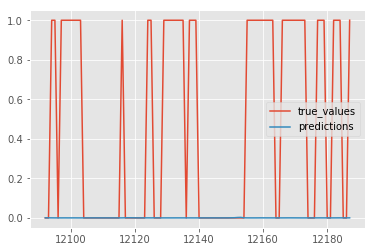

In [26]:
_ = plot_predictions( test_proba[-96:], test_y[-96:] )

In [39]:
save_result_to_file(data_folder_path+'/results/classification_acc/', metrics2['Accuracy'], lag_dict)